# Exploring Machine Learning on Quantopian
Recently, Quantopian’s Chief Investment Officer, Jonathan Larkin, shared an industry insider’s overview of the [professional quant equity workflow](http://blog.quantopian.com/a-professional-quant-equity-workflow/). This workflow is comprised of distinct stages including: (1) Universe Definition, (2) Alpha Discovery, (3) Alpha Combination, (4) Portfolio Construction and (5) Trading.

This Notebook focuses on stage 3: Alpha Combination. At this stage, Machine Learning is an intuitive choice as we have abstracted the problem to such a degree that it is now a classic classification (or regression) problem which ML is very good at solving and coming up with an alpha combination that is predictive.

As you will see, there is a lot of code here setting up a factor library and some data wrangling to get everything into shape. The details of this part are perhaps not quite as interesting so feel free to skip directly to ["Training our ML pipeline"](#training) where we have everything in place to train and test our classifier.

## Overview
1. Define trading universe to use ([Q500US and Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us)).
2. Define alphas (implemented in [Pipeline](https://www.quantopian.com/tutorials/pipeline)).
3. Run pipeline.
4. Split into train and test set.
5. Preprocess data (rank alphas, subsample, align alphas with future returns, impute, scale).
6. Train Machine Learning classifier ([AdaBoost from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).
7. Evaluate Machine Learning classifier on test set.

Note that one important limitation is that we only train and test on static (i.e. fixed-in-time) data. Thus, you can not directly do the same in an algorithm. In principle, this is possible and will be the next step but it makes sense to first focus on just the ML in a more direct way to get a good intuition about the workflow and how to develop a competitive ML pipeline.

### Disclaimer
This workflow is still a bit rough around the edges. We are working on improving it and adding better educational materials. This serves as a sneak-peek for the curious and adventurous.

In [144]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import (
    CustomFactor, SimpleMovingAverage, AverageDollarVolume, Returns, RSI, AnnualizedVolatility
)
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US, QTradableStocksUS
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics
from sklearn.metrics import classification_report

## Definition of some commonly used factors
The factors below are a small collection of commonly used alphas that were coded by Gil Wassermann. I will post a separate Notebook with the full collection and more descriptions of them. Ultimately we will put these into a library you can just import to avoid the wall of text. If you want to understand more about pipeline, read the [tutorial](https://www.quantopian.com/tutorials/pipeline).

Also note the `Earnings_Quality` alpha which uses [Zacks Earnings Surprises](https://www.quantopian.com/data/zacks/earnings_surprises), a [new source from our partners](https://www.quantopian.com/data).

The details of these factors are not the focus of this Notebook so feel free to just [skip](#universe) this cell.

In [154]:
# We'll add more factors once the skeleton is fully developed

# I ended up adding more prior to full development  ¯\_(ツ)_/¯¯\_(ツ)_/¯
# This also means I need to retrain which will happen later. Probs tonight

In [146]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
    
    class AdvancedMomentum(CustomFactor):
        inputs = (USEquityPricing.close, Returns(window_length=126))
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            np.divide(
                (
                    (prices[-21] - prices[-252]) / prices[-252] -
                    prices[-1] - prices[-21]
                ) / prices[-21],
                np.nanstd(returns, axis=0),
                out=out,
            )

    def SMA_return():
        # Short close price average.
        ShortAvg = SimpleMovingAverage(
            inputs=[USEquityPricing.close],
            window_length=3,
        )

        # Long close price average.
        LongAvg = SimpleMovingAverage(
            inputs=[USEquityPricing.close],
            window_length=45,
        )

        return (ShortAvg - LongAvg) / LongAvg
    
    def InfoRatio():
        n = 252
        mu = Returns(window_length=n)
        sigma = AnnualizedVolatility(window_length=n)
        return mu / sigma
                                                               
    all_factors = {
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        #'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        #'Price Oscillator': Price_Oscillator,
        #'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        #'Trendline': Trendline,
        #'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,
        'Advanced Momentum': AdvancedMomentum,
        #'SMA return': SMA_return,
        #'Info Ratio': InfoRatio,
        #'current_ratio': lambda: or_.current_ratio.latest,
        #'long_term_debt_equity_ratio': lambda: or_.long_term_debt_equity_ratio.latest,
        #'pb_ratio': lambda: vr.pb_ratio.latest,
        'book_value_yield': lambda: vr.book_value_yield.latest,
        'assets_turnover': lambda: or_.assets_turnover.latest,
        'diluted_eps_growth': lambda: morningstar.earnings_ratios.diluted_eps_growth.latest,
        'diluted_cont_eps_growth': lambda: morningstar.earnings_ratios.diluted_cont_eps_growth.latest,
        'dps_growth': lambda: morningstar.earnings_ratios.dps_growth.latest,
        'equity_per_share_growth': lambda: morningstar.earnings_ratios.equity_per_share_growth.latest,
        'gross margin': lambda: or_.gross_margin.latest,
        #'financial_leverage': lambda: or_.financial_leverage.latest,
        'pe_ratio': lambda: vr.pe_ratio.latest,
        'ps_ratio': lambda: vr.ps_ratio.latest,    
        'roe': lambda: or_.roe.latest, #These 3 boys bellow are all heavily correlated, but which is best to keep
        'roa': lambda: or_.roa.latest,
        'roic': lambda: or_.roic.latest,
    }
    
    return all_factors

<a></a></a>

## Define universe and select factors to use
We will screen our universe using the new [Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us) and hand-pick a few alphas from the list above. We encourage you to play around with the factors.

In [147]:
universe = Q1500US()

factors = make_factors()

## Define and build the pipeline
Next we have to build the pipeline. In addition to the factors defined above, we need the forward returns we want to predict. In this Notebook we will predict 5-day returns and train our model on daily data. You can also subsample the data to e.g. weekly to not have overlapping return periods but we omit this here.

In [148]:
n_fwd_days = 5 # number of days to compute returns over

In [149]:
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.iteritems()}
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

In [150]:
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

## Run the pipeline

In [151]:
start_timer = time()
start = pd.Timestamp("2016-03-06")
end = pd.Timestamp("2016-09-14")#"2016-09-14"
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()

In [152]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 74.44 secs


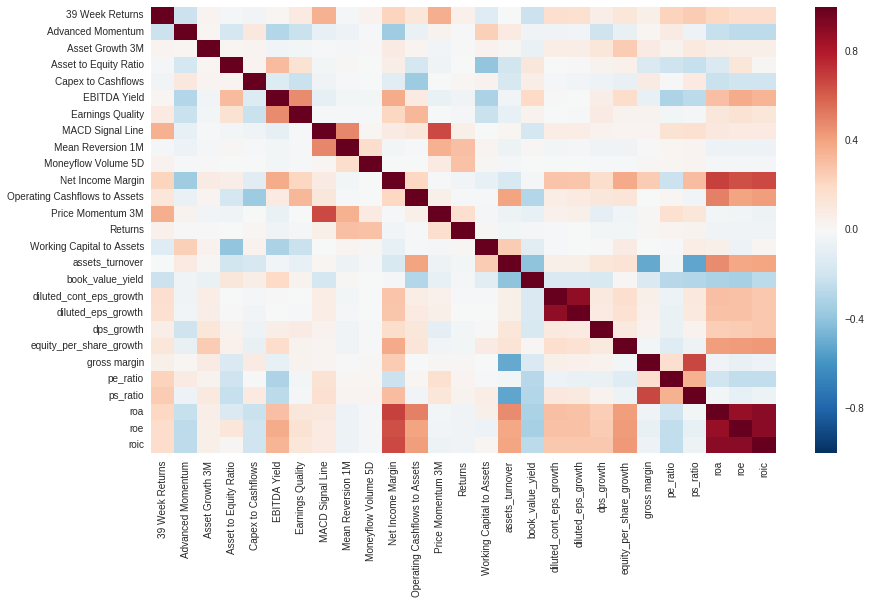

In [153]:
# This a part I would improve upon. Remove correlated factors (+ or -) and maybe add more. Can't be double dipping
# into the same correlated values pool
import seaborn as sns
sns.heatmap(results.corr())

In [103]:
results.head()

39 Week Returns  Asset Growth 3M  \
date                      security                                              
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])             289.0            572.0   
                          Equity(24 [AAPL])            489.0           1040.0   
                          Equity(53 [ABMD])           1403.0           1313.0   
                          Equity(62 [ABT])             548.0            436.0   
                          Equity(67 [ADSK])            800.0            595.0   

                                             Asset to Equity Ratio  \
date                      security                                   
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])                   927.0   
                          Equity(24 [AAPL])                  619.0   
                          Equity(53 [ABMD])                   93.0   
                          Equity(62 [ABT])                   467.0   
                          Equity(67 [ADSK])                  918.0   

                                             Capex to Cashflows  EBITDA Yield  \
date                      security                                              
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])                243.0          23.0   
                          Equity(24 [AAPL])               691.0        1489.0   
                          Equity(53 [ABMD])               627.0         236.0   
                          Equity(62 [ABT])                410.0        1416.0   
                          Equity(67 [ADSK])               681.0         269.0   

                                             Earnings Quality  \
date                      security                              
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])                NaN   
                          Equity(24 [AAPL])            1453.0   
                          Equity(53 [ABMD])             575.0   
                          Equity(62 [ABT])             1328.0   
                          Equity(67 [ADSK])              31.0   

                                             MACD Signal Line  \
date                      security                              
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])              882.0   
                          Equity(24 [AAPL])             307.0   
                          Equity(53 [ABMD])             266.0   
                          Equity(62 [ABT])              345.0   
                          Equity(67 [ADSK])             548.0   

                                             Mean Reversion 1M  \
date                      security                               
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])              1051.0   
                          Equity(24 [AAPL])             1025.0   
                          Equity(53 [ABMD])               66.0   
                          Equity(62 [ABT])               531.0   
                          Equity(67 [ADSK])              911.0   

                                             Moneyflow Volume 5D  \
date                      security                                 
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])                 941.0   
                          Equity(24 [AAPL])               1393.0   
                          Equity(53 [ABMD])                711.0   
                          Equity(62 [ABT])                 460.0   
                          Equity(67 [ADSK])               1088.0   

                                             Net Income Margin  \
date                      security                               
2016-03-07 00:00:00+00:00 Equity(2 [ARNC])               180.0   
                          Equity(24 [AAPL])             1341.0   
                          Equity(53 [ABMD])             1064.0   
                          Equity(62 [ABT])              1148.0   
                          Equity(67 [ADSK])              226.0   

                                             Operating Cashflows to Assets  \
date                     

In [104]:
results.tail()

39 Week Returns  \
date                      security                                 
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])                NaN   
                          Equity(49700 [FCE_A])              NaN   
                          Equity(49925 [NGVT])               NaN   
                          Equity(50049 [FTV])                NaN   
                          Equity(50077 [TWLO])               NaN   

                                                 Asset Growth 3M  \
date                      security                                 
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])              448.0   
                          Equity(49700 [FCE_A])            594.0   
                          Equity(49925 [NGVT])            1414.0   
                          Equity(50049 [FTV])             1347.0   
                          Equity(50077 [TWLO])            1480.0   

                                                 Asset to Equity Ratio  \
date                      security                                       
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])                    484.0   
                          Equity(49700 [FCE_A])                  990.0   
                          Equity(49925 [NGVT])                  1295.0   
                          Equity(50049 [FTV])                    975.0   
                          Equity(50077 [TWLO])                   136.0   

                                                 Capex to Cashflows  \
date                      security                                    
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])                  71.0   
                          Equity(49700 [FCE_A])              1323.0   
                          Equity(49925 [NGVT])                481.0   
                          Equity(50049 [FTV])                 830.0   
                          Equity(50077 [TWLO])               1238.0   

                                                 EBITDA Yield  \
date                      security                              
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])          1274.0   
                          Equity(49700 [FCE_A])          20.0   
                          Equity(49925 [NGVT])          466.0   
                          Equity(50049 [FTV])          1107.0   
                          Equity(50077 [TWLO])          149.0   

                                                 Earnings Quality  \
date                      security                                  
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])              1353.0   
                          Equity(49700 [FCE_A])            1207.0   
                          Equity(49925 [NGVT])              412.0   
                          Equity(50049 [FTV])              1129.0   
                          Equity(50077 [TWLO])              226.0   

                                                 MACD Signal Line  \
date                      security                                  
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])               184.0   
                          Equity(49700 [FCE_A])             705.0   
                          Equity(49925 [NGVT])             1269.0   
                          Equity(50049 [FTV])              1026.0   
                          Equity(50077 [TWLO])             1465.0   

                                                 Mean Reversion 1M  \
date                      security                                   
2016-09-14 00:00:00+00:00 Equity(49666 [AGR])                268.0   
                          Equity(49700 [FCE_A])              469.0   
                          Equity(49925 [NGVT])                30.0   
                          Equity(50049 [FTV])                 11.0   
                          Equity(50077 [TWLO])                22.0   

                                                 Moneyflow Volume 5D  \
date                      security                                     
2016-09-14 00:00:00

As you can see, running pipeline gives us factors for every day and every security, ranked relative to each other. We assume that the order of individual factors might carry some weak predictive power on future returns. The question then becomes: how can we combine these weakly predictive factors in a clever way to get a single mega-alpha which is hopefully more predictive.

This is an important milestone. We have our ranked factor values on each day for each stock. Ranking is not absolutely necessary but has several benefits:

* it increases robustness to outliers,
* we mostly care about the relative ordering rather than the absolute values.

Also note the `Returns` column. These are the values we want to predict given the factor ranks.

Next, we are doing some additional transformations to our data:

1. Shift factor ranks to align with future returns `n_fwd_days` days in the future.
2. Find the top and bottom 30 percentile stocks by their returns. Essentially, we only care about relative movement of stocks. If we later short stocks that go down and long stocks going up relative to each other, it doesn't matter if e.g. all stocks are going down in absolute terms. Moverover, we are ignoring stocks that did not move that much (i.e. 30th to 70th percentile) to only train the classifier on those that provided strong signal. 
3. We also binarize the returns by their percentile to turn our ML problem into a classification one.

`shift_mask_data()` is a utility function that does all of these.

In [158]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary
def get_last_values(input_data):
    last_values = []
    for dataset in input_data:
        last_values.append(dataset[-1])
    return np.vstack(last_values).T

After we have our helper function to align our data properly we pass our factor ranks to it. You might wonder why we have to do the `swapaxes` thing below rather than just using `pandas` logic. The reason is that this way we can use the same `shift_mask_data()` function inside of a factor where we do not have access to a Pandas `DataFrame`. More on that in a future notebook.

In [106]:
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

In [107]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )


In [108]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

In [109]:
results_wo_returns.sample(10).sort()

/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  """Entry point for launching an IPython kernel.


39 Week Returns  Asset Growth 3M  Asset to Equity Ratio  \
date       security                                                            
2016-03-07 CRL                 351.0            383.0                  647.0   
           HP                 1334.0           1295.0                   75.0   
           HT                 1324.0           1092.0                 1163.0   
           HTS                 562.0             19.0                 1435.0   
           IBM                 371.0            178.0                 1305.0   
           JAZZ                680.0           1482.0                   24.0   
           LPLA                983.0            219.0                  307.0   
           MD                  408.0           1111.0                 1369.0   
           NAVI                  NaN              NaN                    NaN   
           PXD                 155.0           1406.0                  149.0   

                     Capex to Cashflows  EBITDA Yield  Earnings Quality  \
date       security                                                       
2016-03-07 CRL                     53.0          31.0            1312.0   
           HP                     751.0         405.0             370.0   
           HT                    1450.0         930.0             967.0   
           HTS                    151.0           8.0              51.0   
           IBM                    276.0        1309.0            1323.0   
           JAZZ                   530.0         605.0             618.0   
           LPLA                   284.0         230.0             521.0   
           MD                     942.0        1391.0            1325.0   
           NAVI                     NaN           NaN               NaN   
           PXD                    423.0         352.0             898.0   

                     MACD Signal Line  Mean Reversion 1M  Moneyflow Volume 5D  \
date       security                                                             
2016-03-07 CRL                  247.0              506.0               1210.0   
           HP                  1285.0              690.0                764.0   
           HT                   602.0              372.0                675.0   
           HTS                  624.0              561.0                364.0   
           IBM                 1236.0             1478.0                929.0   
           JAZZ                 156.0              510.0               1378.0   
           LPLA                1461.0              963.0               1012.0   
           MD                   644.0             1358.0                921.0   
           NAVI                 941.0             1080.0                644.0   
           PXD                 1165.0              515.0                 69.0   

                     Net Income Margin  Operating Cashflows to Assets  \
date       security                                                     
2016-03-07 CRL                    49.0                          753.0   
           HP                   1381.0                          826.0   
           HT                   1321.0                          784.0   
           HTS                    55.0                          431.0   
           IBM                   981.0                         1257.0   
           JAZZ                  928.0                         1377.0   
           LPLA                  939.0                         1110.0   
           MD                   1224.0                          253.0   
           NAVI                  786.0                            NaN   
           PXD                   301.0                          925.0   

                     Price Momentum 3M  Working Capital to Assets  
date       security                                                
2016-03-07 CRL                   899.0                      346.0  
           HP                   1191.0                     1192.0  
           HT                    648.

In [110]:
tmp = (returns > 0.).to_frame()
tmp.index = tmp.index.set_levels(tmp.index.get_level_values(1).map(lambda x: x.symbol), 1)
tmp.columns = ['5-day forward returns > 0']
tmp.sample(10).sort()

/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  after removing the cwd from sys.path.


5-day forward returns > 0
date                      security                          
2016-03-17 00:00:00+00:00 PSMT                          True
2016-04-01 00:00:00+00:00 WIN                           True
2016-04-26 00:00:00+00:00 O                             True
2016-04-29 00:00:00+00:00 ABG                          False
                          MS                            True
2016-05-13 00:00:00+00:00 EQT                          False
2016-05-19 00:00:00+00:00 SFM                          False
2016-07-22 00:00:00+00:00 SR                            True
2016-08-29 00:00:00+00:00 LLY                           True
2016-09-14 00:00:00+00:00 EMN                          False

Next, we split our data into training (70%) and test (30%). This is common practice: our classifier will try to fit the training set as well as possible but it does not tell us how well it would perform on unseen data. Because we are dealing with time-series data we split along the time-dimension to only test on future data.

In [111]:
# Train-test split
train_size_perc = 0.7
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

As we can only exclude stocks that did not move by a lot (i.e. 30th to 70th percentile) during training, we keep all stocks in our test set and just binarize according to the median. This avoids look-ahead bias.

In [112]:
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 836176 but corresponding boolean dimension is 142120
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 836176 but corresponding boolean dimension is 142120
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 836176 but corresponding boolean dimension is 142120
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 836176 but corresponding boolean dimension is 142120
/venvs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: boolean index did not match

In [113]:
X_train_shift.shape, X_test_shift.shape

((78928, 13), (43344, 13))

<a></a></a>

## Training our ML pipeline
Before training our classifier, several preprocessing steps are advisable. The first one imputes nan values with the factor mean to get clean training data, the second scales our factor ranks to be between [0, 1).

For training we are using the [AdaBoost classifier](https://en.wikipedia.org/wiki/AdaBoost) which automatically determines the most relevant features (factors) and tries to find a non-linear combination of features to maximize predictiveness while still being robust. In essence, AdaBoost trains an ensemble of weak classifiers (decision trees in this case) sequentially. Each subsequent weak classifier takes into account the samples (or data points) already classified by the previous weak classifiers. It then focuses on the samples misclassified by the previous weak classifiers and tries to get those correctly. With each new weak classifier you get more fine-grained in your decision function and correctly classify some previously misclassified samples. For prediction, you simply average the answer of all weak classifiers to get a single strong classifier.

Of course, this is just an example and you can let your creativity and skill roam freely.

In [114]:
# Since this process seems to be compuationally expensive on quantopians servers(and they won't let me use my own
# gd gpu), I was only able to play around with a couple of the parameters, but I researched the more impactful
# ones and investigated those. (I payed good money for that gpu)

In [115]:
# An issue that I am very concerned about is the fitting wiht the imputer and the min max scaler
# I think that the transformations are not going through or something strange is happening bc it's necessary
# I have the one simple adaboost model at the beginning of my training for the other ML models to work

In [116]:
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()

In [117]:
start_timer = time()

# Train classifier
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(n_estimators=150) # n_estimators controls how many weak classifiers are fi

X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)
clf.fit(X_train_trans, Y_train_shift)

end_timer = time()

In [118]:
# These bad boys take a while to train, 15-20 mins each, SO I have to rememeber to run these when I go out to eat 
# or head over to Aleesha's 

In [122]:
from sklearn.preprocessing import Imputer
est = [5,10,20,50,150,250]
max_feat = [1,2,5,7,10,13]
for x in est: 
    for y in max_feat:
        start_time = time()
        clf = ensemble.AdaBoostClassifier(n_estimators = x, learning_rate = y, random_state = 42)
        #Tranforming train data 
        X_train_trans = imputer.fit_transform(X_train_shift)
        X_train_trans = scaler.fit_transform(X_train_trans)
        clf.fit(X_train_trans, Y_train_shift)
        #Tranforming test data
        X_test_trans = imputer.transform(X_test_shift)
        X_test_trans = scaler.transform(X_test_trans) 
        # Predicting
        Y_pred = clf.predict(X_test_trans)
        Y_pred_prob = clf.predict_proba(X_test_trans)
        end_time = time()
        # Don't care for results worse than coin flip
        if (metrics.accuracy_score(Y_test_shift, Y_pred) * 100) > 50 :
            print('Test parameters: n_est = ' + str(x) + ', learning_rate = ' + str(y))
            print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
            #print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))
            print("Time to train full ML pipline: %0.2f secs" % (end_time - start_time))
            print('')

Test parameters: n_est = 5, learning_rate = 1
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.32 secs

Test parameters: n_est = 5, learning_rate = 2
Accuracy on test set = 50.04%
Time to train full ML pipline: 0.31 secs

Test parameters: n_est = 5, learning_rate = 5
Accuracy on test set = 50.00%
Time to train full ML pipline: 0.31 secs

Test parameters: n_est = 5, learning_rate = 7
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.28 secs

Test parameters: n_est = 5, learning_rate = 10
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.25 secs

Test parameters: n_est = 5, learning_rate = 13
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.27 secs

Test parameters: n_est = 10, learning_rate = 5
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.46 secs

Test parameters: n_est = 10, learning_rate = 7
Accuracy on test set = 50.02%
Time to train full ML pipline: 0.45 secs

Test parameters: n_est = 10, learning_rate = 10
Accu

In [91]:
from sklearn.ensemble import RandomForestClassifier
est = [5,10,20,50,150,250]
max_feat = [1,2,5,7,10,13]
for x in est: 
    for y in max_feat:
        start_time = time()
        clf = RandomForestClassifier(n_estimators = x, max_features = y, random_state = 42)
        #Tranforming train data 
        X_train_trans = imputer.fit_transform(X_train_shift)
        X_train_trans = scaler.fit_transform(X_train_trans)
        clf.fit(X_train_trans, Y_train_shift)
        #Tranforming test data
        X_test_trans = imputer.transform(X_test_shift)
        X_test_trans = scaler.transform(X_test_trans) 
        # Predicting
        Y_pred = clf.predict(X_test_trans)
        Y_pred_prob = clf.predict_proba(X_test_trans)
        end_time = time()
        if (metrics.accuracy_score(Y_test_shift, Y_pred) * 100) > 50 :
            print('Test parameters: n_est = ' + str(x) + ', max_feat = ' + str(y))
            print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
            print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))
            print "Time to train full ML pipline: %0.2f secs" % (end_time - start_time)
            print('')

Test parameters: n_est = 5, max_feat = 1
Accuracy on test set = 50.33%
Log-loss = 0.87197
Time to train full ML pipline: 0.41 secs

Test parameters: n_est = 5, max_feat = 2
Accuracy on test set = 50.30%
Log-loss = 0.86367
Time to train full ML pipline: 0.54 secs

Test parameters: n_est = 5, max_feat = 5
Accuracy on test set = 50.22%
Log-loss = 0.89219
Time to train full ML pipline: 0.89 secs

Test parameters: n_est = 5, max_feat = 7
Accuracy on test set = 50.23%
Log-loss = 0.91882
Time to train full ML pipline: 1.39 secs

Test parameters: n_est = 5, max_feat = 10
Accuracy on test set = 50.08%
Log-loss = 0.89809
Time to train full ML pipline: 1.88 secs

Test parameters: n_est = 5, max_feat = 13
Accuracy on test set = 50.23%
Log-loss = 0.88800
Time to train full ML pipline: 2.27 secs

Test parameters: n_est = 10, max_feat = 1
Accuracy on test set = 50.24%
Log-loss = 0.71310
Time to train full ML pipline: 0.79 secs

Test parameters: n_est = 10, max_feat = 2
Accuracy on test set = 50.20%
L

In [ ]:
#Ayyyyyy wtf this one did great (comparitively)
# I have no frame of reference for what a good log loss looks like, so I should probs ask.
#Test parameters: n_est = 50, max_feat = 5, random_state = 42
#Accuracy on test set = 50.42%
#Log-loss = 0.69487
#Time to train full ML pipline: 9.58 secs

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
est = [5,10,20,50,150,250]
max_feat = [1,2,5,7,10,13]
start_times = time()
for x in est: 
    for y in max_feat:
        start_time = time()
        clf = GradientBoostingClassifier(n_estimators = x, max_features = y)
        #Tranforming train data 
        X_train_trans = imputer.fit_transform(X_train_shift)
        X_train_trans = scaler.fit_transform(X_train_trans)
        clf.fit(X_train_trans, Y_train_shift)
        #Tranforming test data
        X_test_trans = imputer.transform(X_test_shift)
        X_test_trans = scaler.transform(X_test_trans) 
        # Predicting
        Y_pred = clf.predict(X_test_trans)
        Y_pred_prob = clf.predict_proba(X_test_trans)
        end_time = time()
        if (metrics.accuracy_score(Y_test_shift, Y_pred) * 100) > 50 :
            print('Test parameters: n_est = ' + str(x) + ', max_feat = ' + str(y))
            print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
            print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))
            print "Time to train full ML pipline: %0.2f secs" % (end_time - start_time)
            print('')

Test parameters: n_est = 5, max_feat = 5
Accuracy on test set = 50.03%
Log-loss = 0.69314
Time to train full ML pipline: 0.25 secs



*Exercise*: Use [partial dependence plots](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) to get an understanding of how factor rankings are used to predict future returns.

## Where to go from here
Several knobs can be tweaked to boost performance:

* Add existing factors from the collection above to the data set.
* Come up with new factors 
  * Use [`alphalens`](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) to evaluate an alpha for its predictive power.
  * Look for [novel data sources from our partners](https://www.quantopian.com/data).
  * Look at the [101 Alpha's Project](https://www.quantopian.com/posts/the-101-alphas-project).
* Improve preprocessing of the ML pipeline
  * Is 70/30 the best split? 
  * Should we not binarize the returns and do regression? 
  * Can we add Sector information in some way?
* Experiment with [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).
  * PCA
  * ICA
  * etc.
* Tweak hyper-parameters of `AdaBoostClassifier`.
  * [Use cross-validation to find optimal parameters](http://scikit-learn.org/stable/modules/grid_search.html).
* Try [different classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) of combinations of classifiers.

## Machine Learning competition
If you have something you think works well, post it in this thread. Make sure to test over the same time-period as I have here to keep things comparable. In a month from now, we can test on new data that has aggregated since then and determine who built the best ML pipeline. If there is demand, we might turn this into a proper ML contest.

## Machine Learning resources
If you look for information on how to get started with ML, here are a few resources:

* [Scikit-learn resources](http://scikit-learn.org/stable/presentations.html)
* [Learning scikit-learn: Machine Learning in Python](https://www.amazon.com/dp/1783281936)
* [Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)

## How to put this into an algorithm
As mentioned above, this is not immediately usable in an algorithm. For one thing, there is no `run_pipeline()` in the backtest IDE. It turns out to be rather simple to take the code above and put it into a pipeline `CustomFactor()` where the ML model would automatically get retrained and make predictions. You would then long the `1` predictions and short the `-1` predictions, apply some weighting (e.g. inverse variance) and execute orders. More on these next steps in the future.

## Credits
* Content created by James Christopher and Thomas Wiecki
* Thanks to Sheng Wang for ideas and inspiration.
* Jonathan Larkin, Jess Stauth, Delaney Granizo-Mackenzie, and Jean Bredeche for helpful comments on an earlier draft.

In [159]:
class ML(CustomFactor):
    init = False

    def compute(self, today, assets, out, returns, *inputs):
        # inputs is a list of factors, for example, assume we have 2 alpha signals, 3 stocks,
        # and a lookback of 2 days. Each element in the inputs list will be data of
        # one signal, so len(inputs) == 2. Then each element will contain a 2-D array
        # of shape [time x stocks]. For example:
        # inputs[0]:
        # [[1, 3, 2], # factor 1 rankings of day t-1 for 3 stocks  
        #  [3, 2, 1]] # factor 1 rankings of day t for 3 stocks
        # inputs[1]:
        # [[2, 3, 1], # factor 2 rankings of day t-1 for 3 stocks
        #  [1, 2, 3]] # factor 2 rankings of day t for 3 stocks
        
        if (not self.init) or (today.weekday() == 0): # Monday
            # Instantiate sklearn objects
            self.imputer = preprocessing.Imputer()
            self.scaler = preprocessing.MinMaxScaler()
            self.clf = RandomForestClassifier(n_estimators = 50, max_features = 5, random_state = 42)
            
            # Stack factor rankings
            X = np.dstack(inputs) # (time, stocks, factors)
            Y = returns # (time, stocks)
        
            # Shift data to match with future returns and binarize 
            # returns based on their 
            X, Y = shift_mask_data(X, Y, n_fwd_days=n_fwd_days)
            
            X = self.imputer.fit_transform(X)            
            X = self.scaler.fit_transform(X)
            
            # Fit the classifier
            self.clf.fit(X, Y)
            
            self.init = True

        # Predict
        # Get most recent factor values (inputs always has the full history)
        last_factor_values = get_last_values(inputs)
        last_factor_values = self.imputer.transform(last_factor_values)
        last_factor_values = self.scaler.transform(last_factor_values)

        # Predict the probability for each stock going up 
        # (column 2 of the output of .predict_proba()) and
        # return it via assignment to out.
        out[:] = self.clf.predict_proba(last_factor_values)[:, 1]

In [160]:
from collections import OrderedDict

def make_ml_pipeline(factors, universe, window_length=30, n_fwd_days=5):
    factors_pipe = OrderedDict()
    # Create returns over last n days.
    factors_pipe['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    # Instantiate ranked factors
    for name, f in factors.iteritems():
        factors_pipe[name] = f().rank(mask=universe)
        
    # Create our ML pipeline factor. The window_length will control how much
    # lookback the passed in data will have.
    factors_pipe['ML'] = ML(inputs=factors_pipe.values(), 
                            window_length=window_length + 1, 
                            mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [161]:
ml_pipe = make_ml_pipeline(factors, universe)

In [166]:
start_timer = time()
start = pd.Timestamp("2015-01-01") # Can't choose a much longer time-period or we run out of RAM
end = pd.Timestamp("2016-03-01") # "2016-03-01"

results = run_pipeline(ml_pipe, start_date=start, end_date=end)

end_timer = time()

In [167]:
assets = results.index.levels[1]
pricing = get_pricing(assets, start, end + pd.Timedelta(days=30), fields="open_price")

In [168]:
factor_data = al.utils.get_clean_factor_and_forward_returns(results['ML'], pricing)

Dropped 0.3% entries from factor data: 0.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000000,0.40,0.260928,0.079265,93630,21.559724
2,0.080000,0.48,0.411657,0.039756,89602,20.632216
3,0.300000,0.74,0.511929,0.030281,85804,19.757669
4,0.529057,0.94,0.613780,0.043627,84689,19.500923
5,0.607846,1.00,0.760193,0.077453,80557,18.549468


Returns Analysis


,1D,5D,10D
Ann. alpha,0.022,0.028,0.026
beta,-0.106,-0.101,-0.130
Mean Period Wise Return Top Quantile (bps),0.981,1.102,1.356
Mean Period Wise Return Bottom Quantile (bps),-0.963,-1.646,-1.513
Mean Period Wise Spread (bps),1.943,2.745,2.845


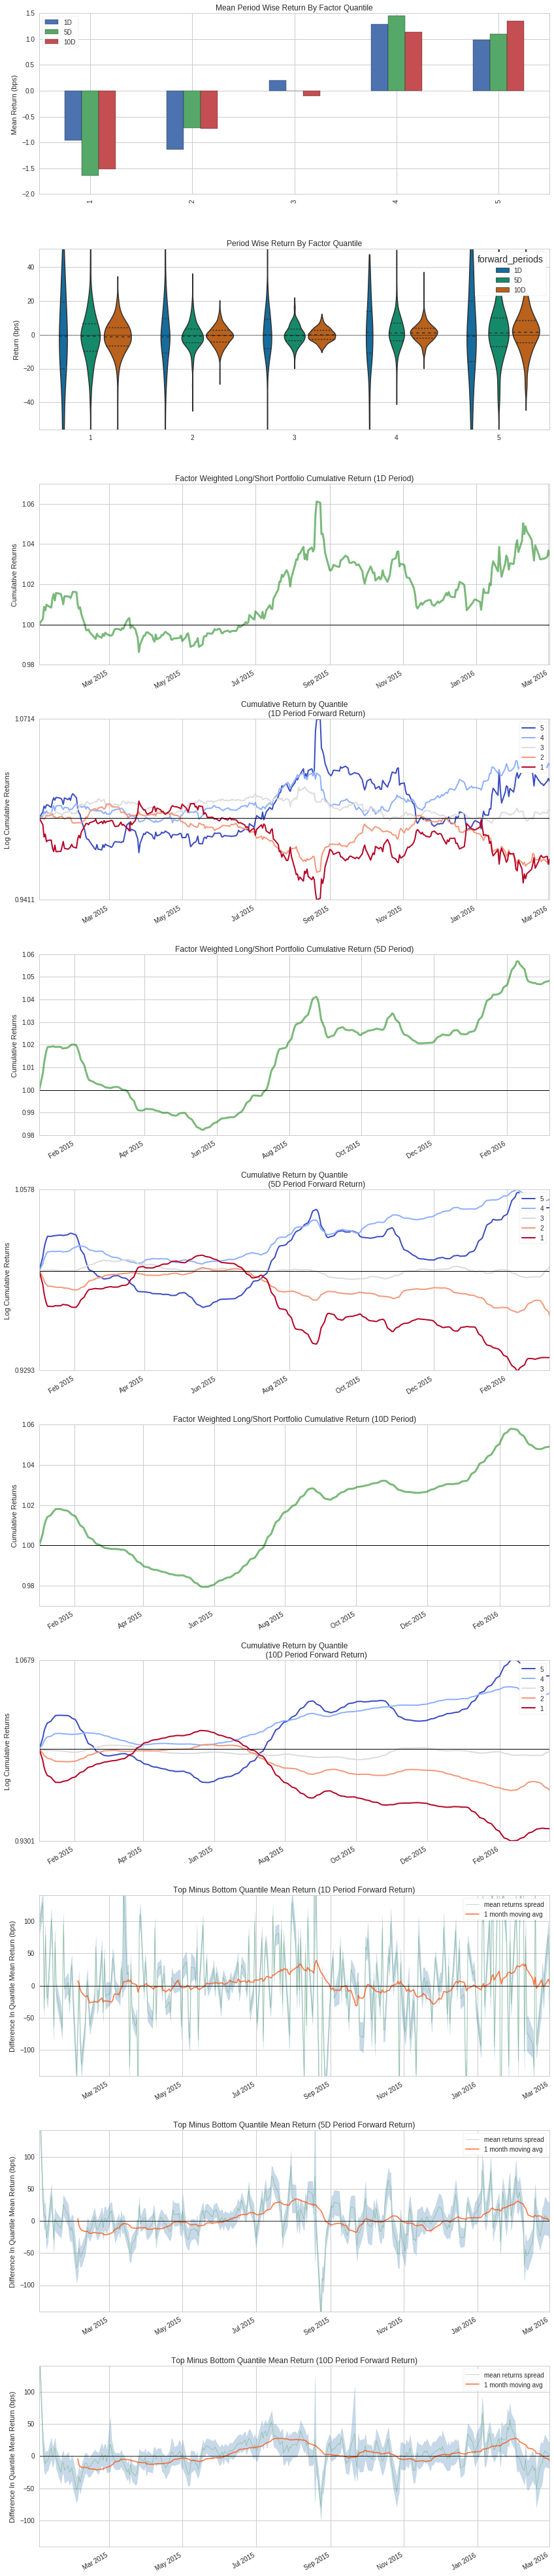

Information Analysis


,1D,5D,10D
IC Mean,0.005,0.008,0.010
IC Std.,0.119,0.125,0.120
Risk-Adjusted IC,0.045,0.063,0.084
t-stat(IC),0.777,1.085,1.439
p-value(IC),0.438,0.279,0.151
IC Skew,-0.042,0.789,0.863
IC Kurtosis,-0.117,6.617,6.165


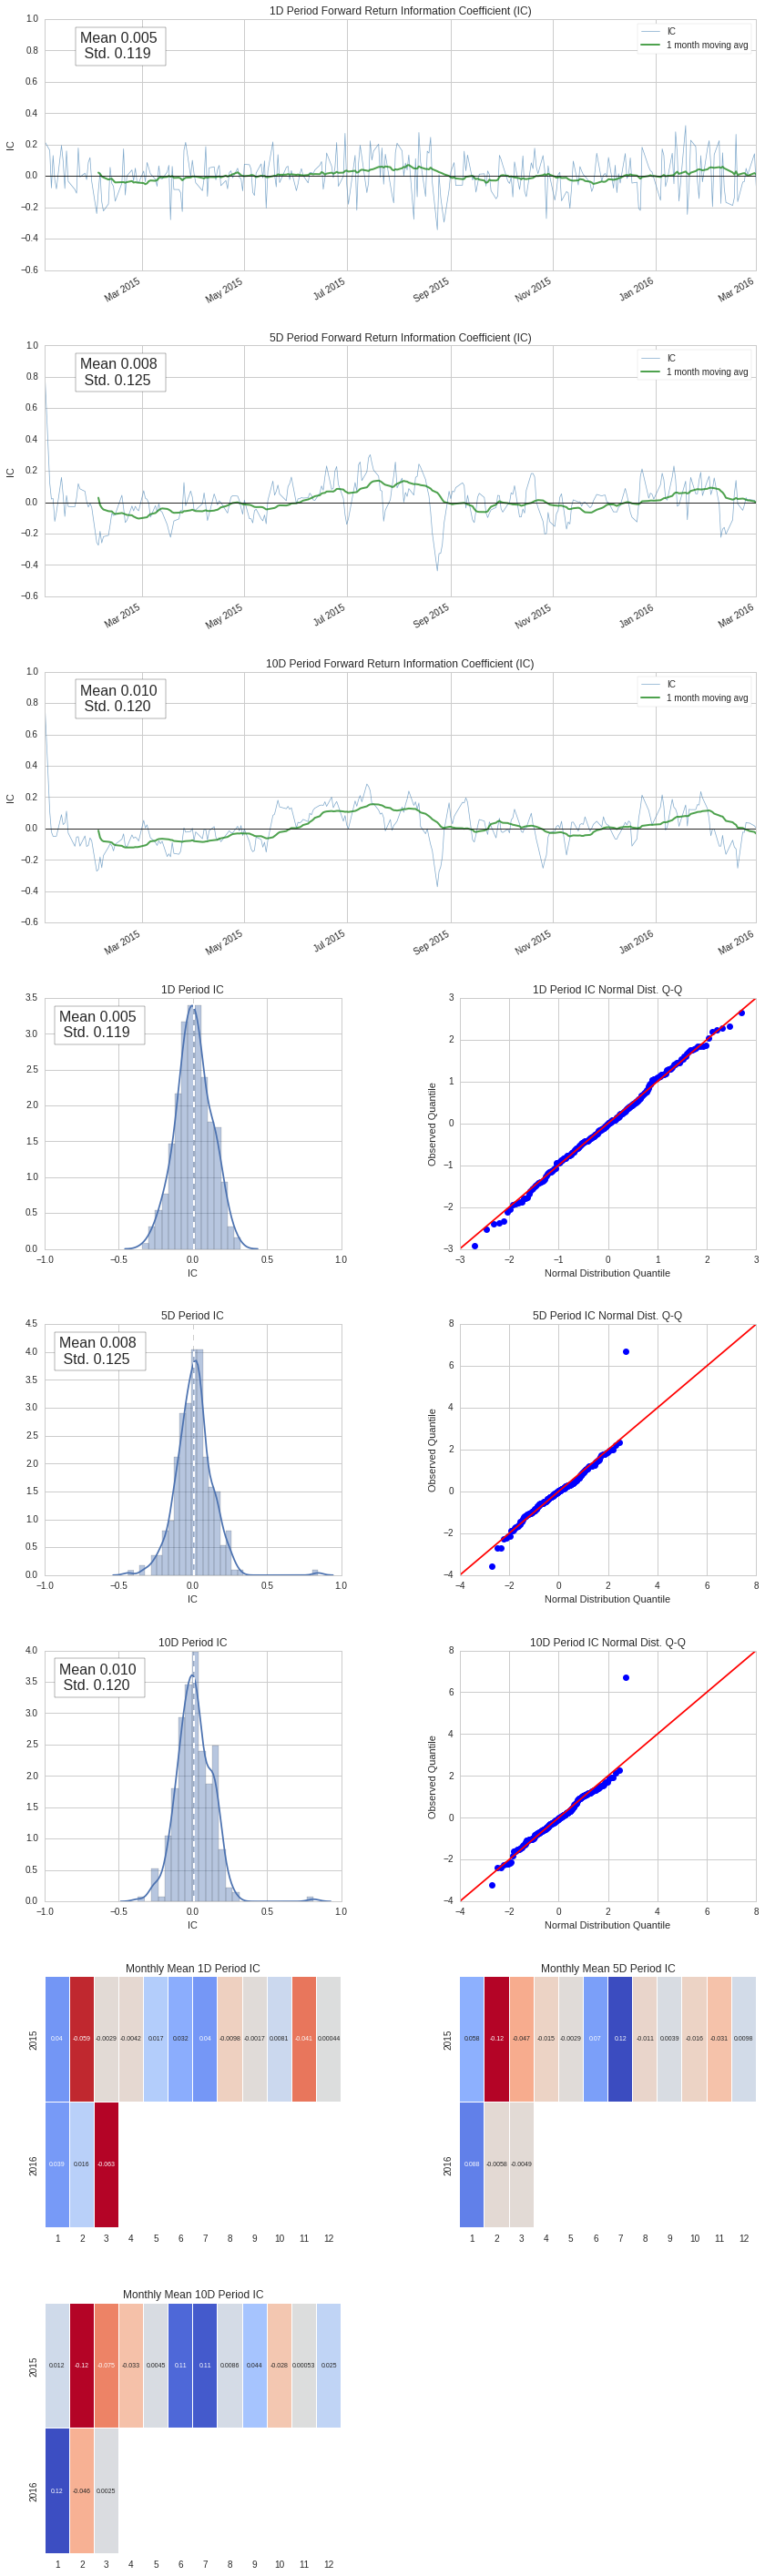

Turnover Analysis


,10D,1D,5D
Quantile 1 Mean Turnover,0.696,0.279,0.600
Quantile 2 Mean Turnover,0.783,0.494,0.751
Quantile 3 Mean Turnover,0.801,0.543,0.775
Quantile 4 Mean Turnover,0.794,0.497,0.756
Quantile 5 Mean Turnover,0.713,0.293,0.614


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.804,0.378,0.211


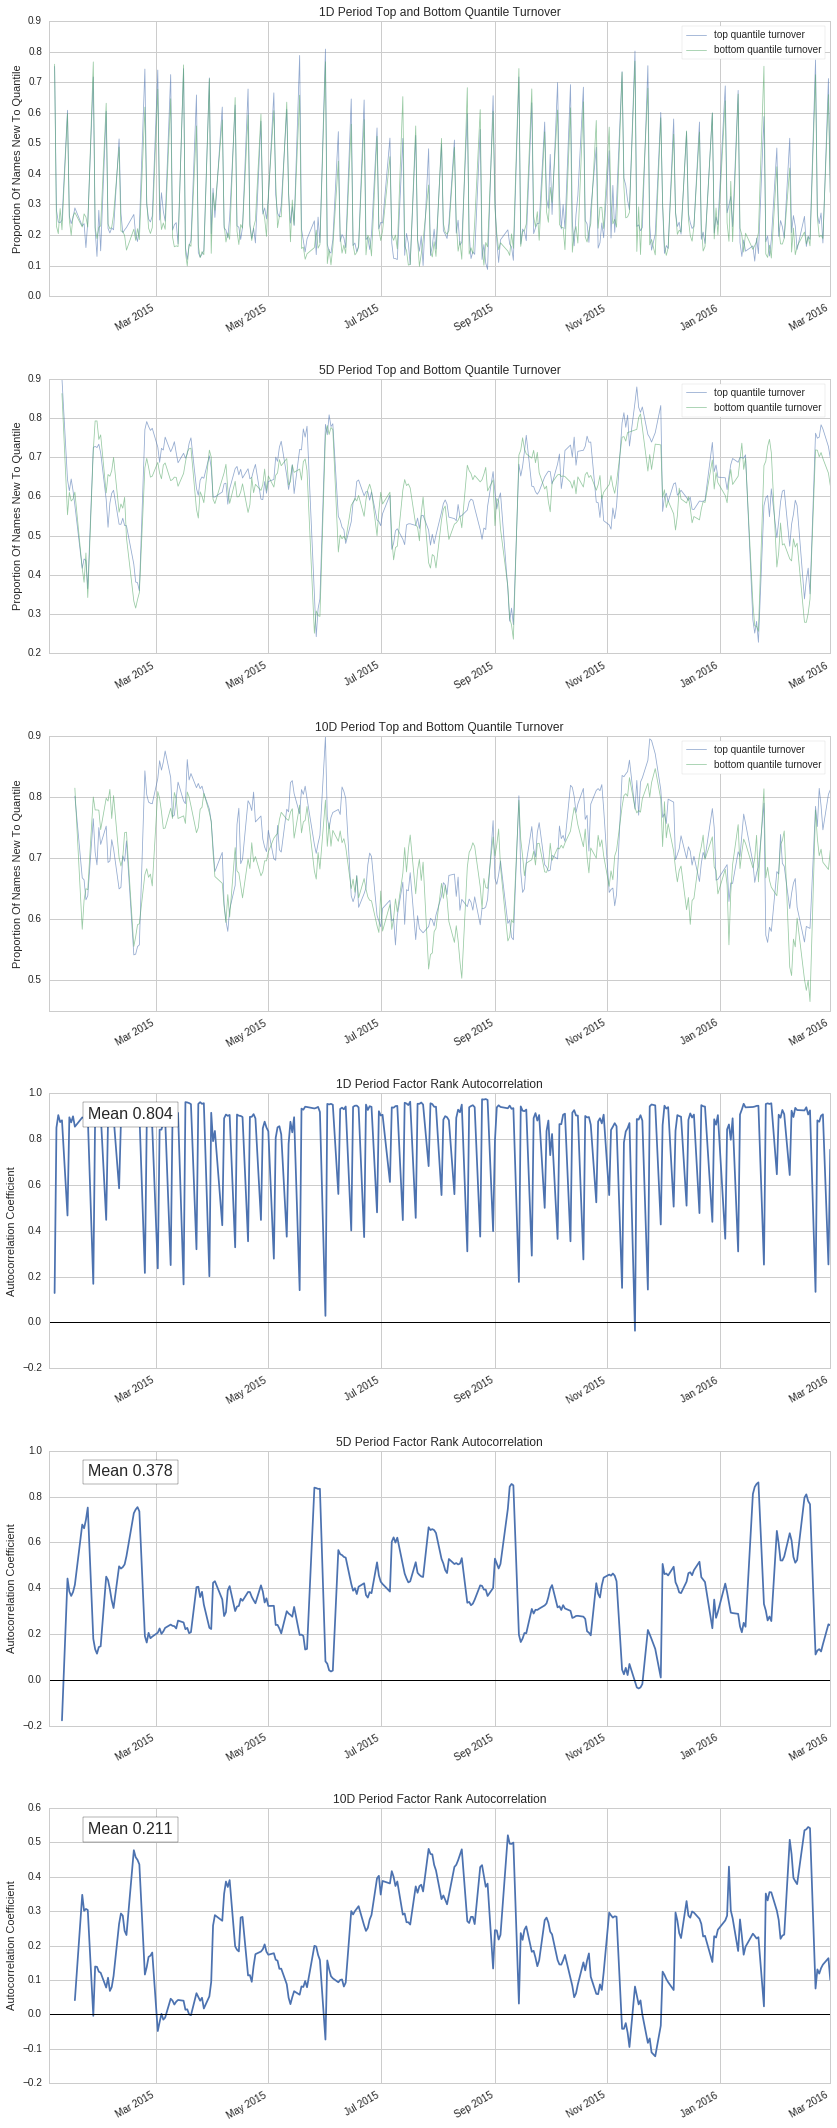

In [169]:
al.tears.create_full_tear_sheet(factor_data)